In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from numpy import log, arctan2, pi, mean
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import meshio

The influence coefficients are computed analytically
as

In [3]:
def influence_coeff(elem, coords, pt_col):
    """Compute influence coefficients

    Parameters
    ----------
    elems : ndarray, int
        Connectivity for the elements.
    coords : ndarray, float
        Coordinates for the nodes.
    pt_col : ndarray
        Coordinates of the colocation point.

    Returns
    -------
    G_coeff : float
        Influence coefficient for flows.
    F_coeff : float
        Influence coefficient for primary variable.
    """
    dcos = coords[elem[1]] - coords[elem[0]]
    dcos = dcos / norm(dcos)
    rotmat = np.array([[dcos[1], -dcos[0]],
                       [dcos[0], dcos[1]]])
    r_A = rotmat.dot(coords[elem[0]] - pt_col)
    r_B = rotmat.dot(coords[elem[1]] - pt_col)
    theta_A = arctan2(r_A[1], r_A[0])
    theta_B = arctan2(r_B[1], r_B[0])
    if norm(r_A) <= 1e-6:
        G_coeff = r_B[1]*(log(norm(r_B)) - 1) + theta_B*r_B[0]
    elif norm(r_B) <= 1e-6:
        G_coeff = -(r_A[1]*(log(norm(r_A)) - 1) + theta_A*r_A[0])
    else:
        G_coeff = r_B[1]*(log(norm(r_B)) - 1) + theta_B*r_B[0] -\
                  (r_A[1]*(log(norm(r_A)) - 1) + theta_A*r_A[0])
    F_coeff = theta_B - theta_A
    return -G_coeff/(2*pi), F_coeff/(2*pi)

The following function evaluate the solution
to the nodes in the 2D mesh.

In [4]:
def eval_sol(ev_coords, coords, elems, u_boundary, q_boundary):
    """Evaluate the solution in a set of points

    Parameters
    ----------
    ev_coords : ndarray, float
        Coordinates of the evaluation points.
    coords : ndarray, float
        Coordinates for the nodes.
    elems : ndarray, int
        Connectivity for the elements.
    u_boundary : ndarray, float
        Primary variable in the nodes.
    q_boundary : [type]
        Flows in the nodes.

    Returns
    -------
    solution : ndarray, float
        Solution evaluated in the given points.
    """
    npts = ev_coords.shape[0]
    solution = np.zeros(npts)
    for k in range(npts):
        for ev_cont, elem in enumerate(elems):        
            pt_col = ev_coords[k]
            G, F = influence_coeff(elem, coords, pt_col)
            solution[k] += u_boundary[ev_cont]*F - q_boundary[ev_cont]*G
    return solution

Now, let us run a simulation.

In [5]:
mesh = meshio.read("files/disk.msh")
elems = np.vstack([cells.data for cells in mesh.cells[0:4]])
bound_nodes = list(set(elems.flatten()))
coords = mesh.points[bound_nodes, :2]
x, y = coords.T
x_m, y_m = 0.5*(coords[elems[:, 0]] + coords[elems[:, 1]]).T
theta = np.arctan2(y_m, x_m)
u_boundary = 3*np.cos(6*theta)
q_boundary = -18*np.cos(6*theta)

In [6]:
ev_coords =  mesh.points[:, :2]
ev_x, ev_y = ev_coords.T
solution = eval_sol(ev_coords, coords, elems, u_boundary, q_boundary)

Visualization

<IPython.core.display.Javascript object>


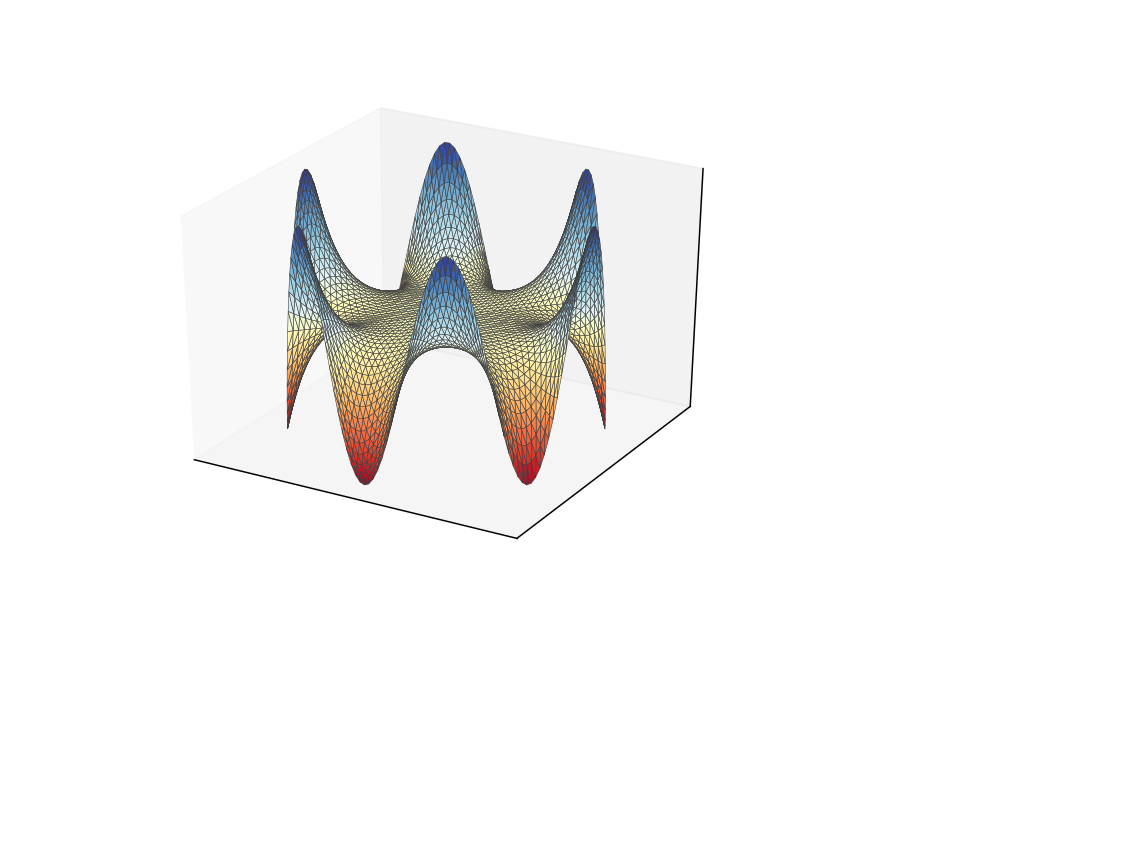

[]

In [7]:
tris = mesh.cells[4]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(ev_x, ev_y, solution, cmap="RdYlBu", lw=0.3,
                edgecolor="#3c3c3c")
plt.xticks([])
plt.yticks([])
ax.set_zticks([])

## Analytical solution

In this case, we can check that the solution is

$$u = 3 r^6\cos(6\theta)\, .$$

In [8]:
import sympy as sym

In [9]:
r, t = sym.symbols("r t")
sol =  3 * r**6 * sym.cos(6*t)

In [10]:
sol_fun = sym.lambdify((r, t), sol)

In [11]:
ev_r = np.sqrt(ev_x**2 + ev_y**2)
ev_t = np.arctan2(ev_y, ev_x)

In [12]:
sol_analytic = sol_fun(ev_r, ev_t)

<IPython.core.display.Javascript object>


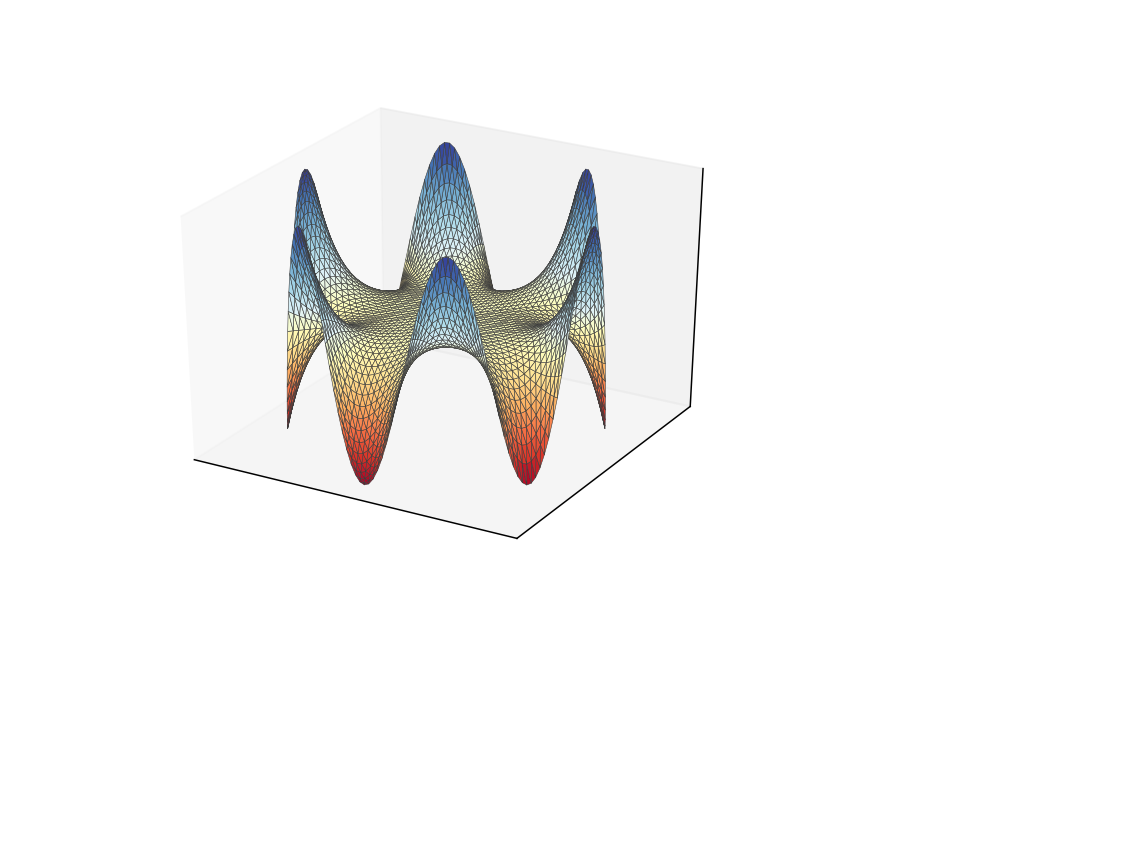

[]

In [13]:
tris = mesh.cells[4]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(ev_x, ev_y, sol_analytic, cmap="RdYlBu", lw=0.3,
                edgecolor="#3c3c3c")
plt.xticks([])
plt.yticks([])
ax.set_zticks([])

<IPython.core.display.Javascript object>


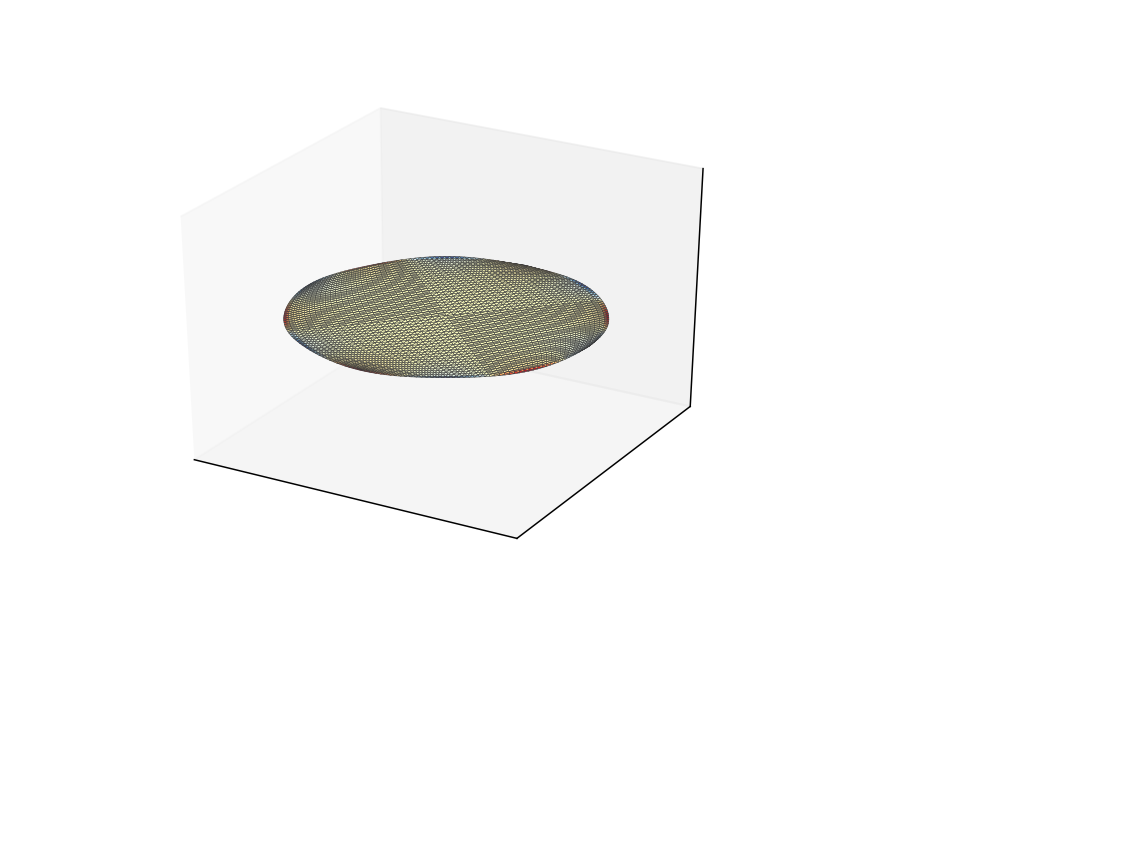

[]

In [14]:
tris = mesh.cells[4]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(ev_x, ev_y, sol_analytic - solution,
                cmap="RdYlBu", lw=0.3,
                edgecolor="#3c3c3c")
ax.set_zlim([-3, 3])
plt.xticks([])
plt.yticks([])
ax.set_zticks([])

In [15]:
rel_error = 100*np.linalg.norm(sol_analytic - solution)/np.linalg.norm(sol_analytic)
rel_error

0.4532963387547446